<center><img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="360" height="160" /></center>

# <center>End to End Memory Network (MemN2N) for Q&A</center>

## Table of Contents

1. [Introduction](#section1)<br>
2. [The Task](#section2)<br>
  - 2.1 [bAbI Dataset](#section2.1)<br>
3. [Getting data](#section3)<br>    
  - 3.1 [Importing Libraries](#section301)<br>
  - 3.2 [Downloading Data](#section302)<br>
4. [Data Pre-processing](#section4)<br>
  - 4.1 [Tokenization](#section401)<br>
  - 4.2 [Data parsing](#section402)<br>
  - 4.3 [Getting User Stories](#section403)<br>
  

5. [Feature Extraction](#section5)<br>
6. [ Understanding & Building Memory Network Model](#section6)<br>
  - 6.1 [Input Memory Representation](#section601)<br>
  - 6.2 [Question Memory Representation](#section602)<br>
  - 6.3 [Output Memory Representation](#section603)<br>
  - 6.4 [Final Prediction](#section604)<br>
7. [Building the Model](#section7)<br>
  - 7.1 [Importing Libraries](#section701)<br>
  - 7.2 [Config file (Parameters)](#section702)<br>
  - 7.3 [Defining the Model](#section703)<br>
8. [Training the Model](#section8)<br>
  - 8.1 [Visualization](#section801)<br>
  - 8.2 [Build the model](#section802)<br>
  - 8.3 [Tests the model over the test data](#section803)<br>





<a id="section1"></a>
## 1. Introduction


<center><img src="https://i2.wp.com/appliedmachinelearning.blog/wp-content/uploads/2019/04/qa_system.png?resize=400%2C248&ssl=1"/></center>

__Question answering system__ is a field of __information retrieval__ and __natural language processing__ which is concerned with building systems that automatically answer questions asked by a human.

Ideally, the task would like a English reading comprehension task where given a passage or paragraph, system would be able to process texts, understand it and __correctly answer the questions__ from the passage like we human do.

So, let’s start with understanding and building the model proposed by __Facebook AI research in 2015__ in this paper [End to End Memory Networks](https://arxiv.org/abs/1503.08895)

<a id="section2"></a>
## 2. The Task



- In 2015, __Facebook__ came up with a __bAbI data-set__ and 20 toy tasks for testing text understanding and reasoning in the bAbI project.

- The tasks are described in detail in the [paper here](https://arxiv.org/abs/1502.05698#) .

- The aim is that each task tests a unique aspect of text and reasoning, and hence test different capabilities of learning models. 

<a id="section201"></a>
### 2.1 bAbI Dataset

For the aforementioned task, we have 10,000 training examples and 1000 testing examples.


The file format for the task is as follows:

ID text

ID text

ID text

ID question[tab]answer[tab]supporting_fact ID.

Each sentence is provided with an ID. 

- The __IDs__ for a given __story__ start at __1__ and __increase__. 

- When the __IDs__ in a file reset back to 1 you can consider the __following sentences__ as a new “story”. 
- __Supporting fact ID__ refer to the __sentences__ within a “story”.

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/Ques%26Ans.png"/></center>

<a id="section3"></a>
## 3. Getting data

<center><img src="https://datatherapy.files.wordpress.com/2015/02/askingn-data-questons1.png"/></center>

<a id="section301"></a>
### 3.1 Importing Libraries

In [ ]:
from __future__ import print_function
from functools import reduce
import re
import tarfile

import numpy as np

from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers
from keras.layers import recurrent
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


<a id="section302"></a>

### 3.2 Downloading Data

In [ ]:
try:
    #tar.gz data-set get saved on "~/.keras/datasets/" path
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise
 
#reading a tar.gz file
tar = tarfile.open(path)

11747328/11745123 [==============================] - 0s 0us/step


The data-set can also be downloaded from [here](https://www.dropbox.com/s/iglkh5xswzr1dqj/en-10k.zip?dl=0) manually.

<a id="section4"></a>

## 4. Data Pre-processing

<a id="section401"></a>
### 4.1 Tokenization
-  Return the tokens of a sentence including punctuation

In [ ]:
def tokenize(sent):
    '''
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split(r'(\W+)', sent) if x.strip()]

<a id="section402"></a>

### 4.2 Data parsing 

-  __Parse stories__ provided in the __bAbi tasks__ format.

- If `only_supporting` is **true**, only the sentences that support the answer are kept.
    

In [ ]:
def parse_stories(lines, only_supporting=False):
  
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data

<a id="section403"></a>
### 4.3 Getting User Stories 

In [ ]:
def get_stories(f):
    '''
    argument: filename
    returns list of all stories in the argument data-set file
    '''
    # read the data file and parse 10k stories
    data = parse_stories(f.readlines())
    # lambda func to flatten the list of sentences into one list
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    # creating list of tuples for each story
    data = [(flatten(story), q, answer) for story, q, answer in data]
    return data

Further, we use the above helper functions to get the train and test stories.

In [ ]:
challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
print('Extracting stories for the challenge: single_supporting_fact_10k')
# Extracting train stories
train_stories = get_stories(tar.extractfile(challenge.format('train')))
# Extracting test stories
test_stories = get_stories(tar.extractfile(challenge.format('test')))

Extracting stories for the challenge: single_supporting_fact_10k


- To validate that the __stories__ are __extracted properly__, we can simply check the __number of stories__ in __train__ and __test__ stories variables. Also, let us see how a story looks like as of now.

In [ ]:
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
train_stories[0]

Number of training stories: 10000
Number of test stories: 1000


(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'John',
  'went',
  'to',
  'the',
  'hallway',
  '.'],
 ['Where', 'is', 'Mary', '?'],
 'bathroom')

<a id="section5"></a>
## 5.  Feature Extraction

- Let us first write a __helper function__ to __vectorize__ each stories in order to fetch it to __memory network model__ which we will be creating __later__. Beacause algorithm only understand the number.



In [ ]:
for story, query, answer in train_stories[:10]:
#   print(story,query,answer)
  x = [[w] for w in story]
  print(x)

[['Mary'], ['moved'], ['to'], ['the'], ['bathroom'], ['.'], ['John'], ['went'], ['to'], ['the'], ['hallway'], ['.']]
[['Mary'], ['moved'], ['to'], ['the'], ['bathroom'], ['.'], ['John'], ['went'], ['to'], ['the'], ['hallway'], ['.'], ['Daniel'], ['went'], ['back'], ['to'], ['the'], ['hallway'], ['.'], ['Sandra'], ['moved'], ['to'], ['the'], ['garden'], ['.']]
[['Mary'], ['moved'], ['to'], ['the'], ['bathroom'], ['.'], ['John'], ['went'], ['to'], ['the'], ['hallway'], ['.'], ['Daniel'], ['went'], ['back'], ['to'], ['the'], ['hallway'], ['.'], ['Sandra'], ['moved'], ['to'], ['the'], ['garden'], ['.'], ['John'], ['moved'], ['to'], ['the'], ['office'], ['.'], ['Sandra'], ['journeyed'], ['to'], ['the'], ['bathroom'], ['.']]
[['Mary'], ['moved'], ['to'], ['the'], ['bathroom'], ['.'], ['John'], ['went'], ['to'], ['the'], ['hallway'], ['.'], ['Daniel'], ['went'], ['back'], ['to'], ['the'], ['hallway'], ['.'], ['Sandra'], ['moved'], ['to'], ['the'], ['garden'], ['.'], ['John'], ['moved'], ['to'

In [ ]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    xs = []
    xqs = []
    ys = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return (pad_sequences(xs, maxlen=story_maxlen),
            pad_sequences(xqs, maxlen=query_maxlen), np.array(ys))

The following snippet creates a __vocabulary dictionary__ and __extract__ word indices vectors as input features.

In [ ]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

# creating index to word dictionary
idx_word = dict((i+1, c) for i,c in enumerate(vocab))

inputs_train, queries_train, answers_train= vectorize_stories(train_stories, word_idx, story_maxlen, query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories, word_idx, story_maxlen, query_maxlen)

print('vocab = {}'.format(vocab))
# print('x.shape = {}'.format(x.shape))
# print('xq.shape = {}'.format(xq.shape))
# print('y.shape = {}'.format(y.shape))
# print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))


vocab = ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'back', 'bathroom', 'bedroom', 'garden', 'hallway', 'is', 'journeyed', 'kitchen', 'moved', 'office', 'the', 'to', 'travelled', 'went']


In [ ]:
print('-------------------------')
print('Vocabulary:\n',vocab,"\n")
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-------------------------')

-------------------------
Vocabulary:
 ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'back', 'bathroom', 'bedroom', 'garden', 'hallway', 'is', 'journeyed', 'kitchen', 'moved', 'office', 'the', 'to', 'travelled', 'went'] 

Vocab size: 22 unique words
Story max length: 68 words
Query max length: 4 words
Number of training stories: 10000
Number of test stories: 1000
-------------------------


In [ ]:
print('-------------------------')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('query train sample', queries_train[0,:])
print('-------------------------')

-------------------------
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 4)
queries_test shape: (1000, 4)
query train sample [ 7 13  5  2]
-------------------------


In [ ]:
print('-------------------------')
print('answers: binary (1 or 0) tensor o&amp;amp;amp;amp;lt;span id="mce_SELREST_start" style="overflow:hidden;line-height:0;"&amp;amp;amp;amp;gt;&amp;amp;amp;amp;lt;/span&amp;amp;amp;amp;gt;f shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('answer train sample', answers_train[0,:])
print('-------------------------')

-------------------------
answers: binary (1 or 0) tensor o&amp;amp;amp;amp;lt;span id="mce_SELREST_start" style="overflow:hidden;line-height:0;"&amp;amp;amp;amp;gt;&amp;amp;amp;amp;lt;/span&amp;amp;amp;amp;gt;f shape (samples, vocab_size)
answers_train shape: (10000, 22)
answers_test shape: (1000, 22)
answer train sample [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------


#### Now What ..

- Till here what ever we did is all about data pre-processing.

- __i.e__ Preparing data for training the model.





Before we delve into model building let's first get the basic intuition of __End to End Memory Netowork__.


<a id="section6"></a>
## 6. Understanding & Building Memory Network Model

To understand the __end to end memory network__ model, let us define few __memory representation vectors__ and its __computation first__.

<a id='section601'></a>
### 6.1 Input Memory Representation

- The story vectors derived from __vocabulary (previous article)__ are converted into __memory vectors__ of dimension __d__ (here, assume embedding_size __d=50__) computed by __embedding layer__.

- An embedding layer takes story vector (__max length 68__) as input and generates a fixed ‘d’ dimensional vector for each input story vector.

- Let us call this __embedding m__. Dimension of ‘m’ would be (__max_story_length, embedding_size__),  i. e. __(68,50)__.

<a id="section602"></a>
### 6.2  Question Memory Representation

- The query vector is also embedded (again, via another embedding layer in keras with the same dimensions as __d__ __(here d=50)__ to obtain an embedding __q__.

- The embedding layer takes query vector (max length 4) as input and generates an embedding __q__ of __d__ dimension.

- Dimension of __q__ would be (query_length, embedding_size) i.e. __(4,50)__.

- Further, In the __embedding space__, we compute the probability vector __p__ i.e. match between __q__ and each memory __m__ by taking the inner product followed by a __softmax function__:

<center><b>p = Softmax(dot(m,q))</b></center>

<br> 
- Dimension of __p__ would be (__max_story_length, query_length__),  i. e. __(68,4)__

<a id="section603"></a>
### 6.3 Output Memory Representation

- The story vector are also converted into memory vector of dimension query max length i.e. 4 computed by a separate embedding layer.

- This embedding layer takes story vector (__max length 68__) vector as input and generates an embedding of __max length=4__ dimension.

- Let us call this embedding __c__.

- Dimension of __c__ would be (max_story_length, query_length), i.e. **(68,4)**.

- The output vector or response vector  __o__ is then calculated by sum over the transformed embedding __c__ , weighted by the probability vector __p__ calculated earlier:

<center><b>o = add(c,p)</b></center>

<br> 
- Dimension of __o__ would be (max_story_length, query_length) i. e. __(68,4)__

<a id="section604"></a>
### 6.4 Final Prediction

- The output or response vector ‘o’ and the input vector ‘m’ are concatenated to form a result vector ‘r’ which is further passed to LSTM layer and finally to output Dense layer of vocabulary size which gives softmax probability of each word in the vocab.

- We consider the word predicted with greater accuracy as answer word. Dimension after concatenation would be (query_length,  embedding_size + max_story_length) i.e. (4, 118).


<br>

<center><b>answer = Softmax(Dense(LSTM(concat(o,q))))</b></center>

<br> 
- or we can write it as

<center><b>answer = Softmax(W(concat(o,q)))</b></center>

## 7.  Building the Model


Hope the above section gave pretty clear illustration on prediction of answer word through the memory network model.

Let us quickly build an end to end single layer memory network model.

<a id="section701"></a>
#### 7.1 Importing Libraries

In [ ]:
import IPython
import matplotlib.pyplot as plt
import pandas as pd
 
import keras
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Permute, dot, add, concatenate
from keras.layers import LSTM, Dense, Dropout, Input, Activation


<a id="section702"></a>
#### 7.2 Config file (Parameters)

In [ ]:
# number of epochs to run
train_epochs = 100
# Training batch size
batch_size = 32
# Hidden embedding size
embed_size = 50
# number of nodes in LSTM layer
lstm_size = 64
# dropout rate
dropout_rate = 0.30

<a id='section703'></a>
#### 7.3  Defining the Model

In [ ]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))
 
print('Input sequence:', input_sequence)
print('Question:', question)
 
# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, embedding_dim)
 
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(dropout_rate))
# output: (samples, story_maxlen, query_maxlen)
 
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=query_maxlen))
question_encoder.add(Dropout(dropout_rate))
# output: (samples, query_maxlen, embedding_dim)
 
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)
 
# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
print(match.shape)
match = Activation('softmax')(match)
print('Match shape', match)
 
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)
print('Response shape', response)
 
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)



Input sequence: Tensor("input_1:0", shape=(?, 68), dtype=float32)
Question: Tensor("input_2:0", shape=(?, 4), dtype=float32)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Input encoded m Tensor("sequential_1/dropout_1/cond/Merge:0", shape=(?, 68, 50), dtype=float32)
Input encoded c Tensor("sequential_2/dropout_2/cond/Merge:0", shape=(?, 68, 4), dtype=float32)
Question encoded Tensor("sequential_3/dropout_3/cond/Merge:0", shape=(?, 4, 50), dtype=float32)
(?, 68, 4)
Match shape Tensor("activation_1/truediv:0", shape=(?, 68, 4), dtype=float32)
Response shape Tensor("permute_1/transpose:0", shape=(?, 4, 68), dtype=float32)
Answer shape Tensor("concatenate_1/concat:0", shape=(?, 4, 118), dtype=float32)


- In the above code snippet, you can see we have two inputs : input_sequence (story) and question (query).

- Also, we have ‘answer’ as a final model which combines response model and encoded query as input and predicts the answer word.


<a id="section8"></a>
## 8. Training the Model

<a id='section810'></a>
### 8.1 Visualization


- The below python function shows visualization of training and validation categorical cross entropy loss as well as  train and validation accuracy over iterations.

- It is a callback function while model training.

In [ ]:
class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()

<a id="section802"></a>
### 8.2 Build the model 

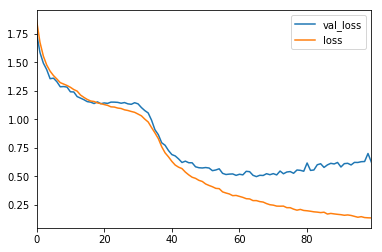

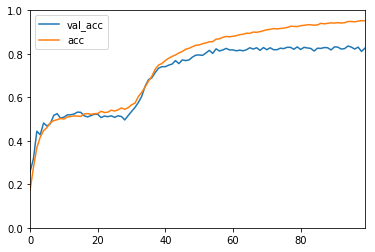

In [ ]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
 
print(model.summary())
 
# start training the model
model.fit([inputs_train, queries_train],
         answers_train, batch_size, train_epochs,
         callbacks=[TrainingVisualizer()],
         validation_data=([inputs_test, queries_test], answers_test))
 
# save model
model.save('model.h5')

<a id="section803"></a>
### 8.3 Tests the model over the test data

Let us check a few of the test stories and see how the model performs in predicting the right answer to the query.

In [ ]:
for i in range(0,10):
    current_inp = test_stories[i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
    current_prediction = model.predict([current_story, current_query])
#     print(current_prediction)
#     print(np.argmax(current_prediction))
    current_prediction = idx_word[np.argmax(current_prediction)]
    
    print(current_prediction)
    print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
    print("--------------------------------------------------------------")


hallway
John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: hallway | Ground Truth: hallway
--------------------------------------------------------------
hallway
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . Where is Mary ? | Prediction: hallway | Ground Truth: bathroom
--------------------------------------------------------------
kitchen
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Where is Sandra ? | Prediction: kitchen | Ground Truth: kitchen
--------------------------------------------------------------
hallway
John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . John went to the hallway . Sandra journeyed to the kitchen . Sandra travelled to